In [1]:
#| default_exp geometry

In [2]:
#| export

import numpy as np
import igl

In [3]:
#| export

import jax
import jax.numpy as jnp
import jax.experimental.sparse as jsparse

import dataclasses

import lineax

import functools

In [4]:
#| export

from jaxtyping import Float 

In [5]:
#| export

from triangulax import trigonometry as trig
from triangulax import mesh as msh
from triangulax import adjacency as adj

In [6]:
#| hide

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
jax.config.update('jax_log_compiles', False) # use this to log JAX JIT compilations.

In [7]:
#| hide

import jaxtyping


In [8]:
#| hide

%load_ext jaxtyping 
%jaxtyping.typechecker beartype.beartype

# enables type checking. does not work for some cells (vmapping and loading/saving). For those, %unload_ext jaxtyping 


## Mesh geometry

Using the half-edge mesh and the adjacency-like operators it defines, we can compute all sorts of geometric quantities of interest: egde lengths, cell areas, curvature in 3d, etc.


#### Discrete exterior calculus and discrete hodge star

Note: the quantities triangle area, cell area, edge length, and dual edge lengths are what's required for DEC.

In [9]:
from triangulax.triangular import TriMesh

In [10]:
# load test data

mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = msh.HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)
geommesh = msh.GeomMesh(*hemesh.n_items, mesh.vertices, mesh.face_positions)

mesh_3d = TriMesh.read_obj("test_meshes/disk.obj", dim=3)
geommesh_3d = msh.GeomMesh(*hemesh.n_items, mesh_3d.vertices, mesh_3d.face_positions)

  o flat_tri_ecmc
  o flat_tri_ecmc


### Basic mesh geometry

In [11]:
#| export

def get_he_length(vertices: Float[jax.Array, "n_vertices dim"], hemesh: msh.HeMesh
                  ) -> Float[jax.Array, " n_hes"]:
    """Get lengths of half-edges (triangulation/primal edges)."""
    return jnp.linalg.norm(vertices[hemesh.orig]-vertices[hemesh.dest], axis=-1)


In [133]:
#| export

## triangle areas and normals

def get_triangle_areas(vertices: Float[jax.Array, "n_vertices dim"], hemesh: msh.HeMesh
                       ) ->Float[jax.Array, "n_faces ..."]:
    """Compute triangle areas in a mesh."""
    return jax.vmap(trig.get_triangle_area)(*vertices[hemesh.faces.T])

def get_oriented_triangle_areas(vertices: Float[jax.Array, "n_vertices dim"], hemesh: msh.HeMesh
                                ) ->Float[jax.Array, "n_faces ..."]:
    """Compute oriented triangle areas in a mesh. In 3d, this is a vector."""
    return jax.vmap(trig.get_oriented_triangle_area)(*vertices[hemesh.faces.T])

def get_triangle_normals(vertices: Float[jax.Array, "n_vertices dim"], hemesh: msh.HeMesh
                         ) ->Float[jax.Array, "n_faces ..."]:
    """Compute normals. In 2d, this just returns +/-1."""
    oriented_areas = get_oriented_triangle_areas(vertices, hemesh)
    norm = jnp.clip(jnp.linalg.norm(oriented_areas, axis=-1), 1e-12)
    return (oriented_areas.T / norm).T

def get_vertex_normals(vertices: Float[jax.Array, "n_vertices dim"], hemesh: msh.HeMesh
                       ) ->Float[jax.Array, "n_faces ..."]:
    """Compute per-vertex normals by averaging over faces"""
    oriented_areas = get_oriented_triangle_areas(vertices, hemesh)
    oriented_areas_vertex = adj.sum_face_to_vertex(oriented_areas)
    norm = jnp.clip(jnp.linalg.norm(oriented_areas_vertex, axis=-1), 1e-12)
    return (oriented_areas_vertex.T / norm).T

def get_dihedral_angles(vertices: Float[jax.Array, "n_vertices dim"], hemesh: msh.HeMesh
                       ) ->Float[jax.Array, "n_hes ..."]:
    """Get dihedral angles (angle between adjacent face normals)."""
    oriented_areas = get_oriented_triangle_areas(vertices, hemesh)
    dihedral = jax.vmap(trig.get_angle_between_vectors)(oriented_areas[hemesh.heface],
                                                        oriented_areas[hemesh.twin[hemesh.heface]])
    return dihedral

In [71]:
#| export

def get_voronoi_face_positions(vertices: Float[jax.Array, "n_vertices 2"], hemesh: msh.HeMesh
                               ) -> Float[jax.Array, "n_faces 2"]:
    """Get face positions of geommesh to the circumcenters of the faces defined by hemesh."""
    face_positions = jax.vmap(trig.get_circumcenter)(*vertices[hemesh.faces].transpose((1,0,2)))
    return face_positions

def set_voronoi_face_positions(geommesh: msh.GeomMesh, hemesh: msh.HeMesh
                               ) -> msh.GeomMesh:
    """Set face positions of geommesh to the circumcenters of the faces defined by hemesh."""
    face_positions = get_voronoi_face_positions(geommesh.vertices, hemesh)
    return dataclasses.replace(geommesh, face_positions=face_positions)

In [122]:
#| export

## Note: these quantities are currently accurate in 2D only (i.e. for planar dual cells)

def get_dual_he_length(face_positions: Float[jax.Array, "n_faces dim"], hemesh: msh.HeMesh
                       ) -> Float[jax.Array, " n_hes"]:
    """Get lengths of dual/cell half-edges."""
    dual_edges = face_positions[hemesh.heface]-face_positions[hemesh.heface[hemesh.twin]]
    return jnp.linalg.norm(dual_edges, axis=-1)

def get_oriented_dual_he_length(vertices: Float[jax.Array, "n_vertices 2"],
                                face_positions: Float[jax.Array, "n_faces 2"],
                                hemesh: msh.HeMesh) -> Float[jax.Array, " n_hes"]:
    """Compute lengths of dual edges. Boundary dual edges get length 1. Negative sign = flipped edge."""
    dual_edges = face_positions[hemesh.heface]-face_positions[hemesh.heface[hemesh.twin]]

    edges = vertices[hemesh.orig]-vertices[hemesh.dest]
    edges_normalized = (edges.T / jnp.linalg.norm(edges, axis=-1)).T
    signed_dual_length = jnp.einsum('vi,vi->v', edges_normalized, dual_edges @ trig.get_rot_mat(np.pi/2))
    signed_dual_length = jnp.where(hemesh.is_bdry_edge, 1, signed_dual_length)
    return signed_dual_length

In [125]:
a = get_dual_he_length(mesh.face_positions, hemesh)
b = get_oriented_dual_he_length(mesh.vertices, mesh.face_positions, hemesh)

jnp.allclose(a[~hemesh.is_bdry_edge], jnp.abs(b)[~hemesh.is_bdry_edge])

Array(True, dtype=bool)

In [73]:
# edges and dual edges should be orthogonal since we are using circumcenters

face_positions = get_voronoi_face_positions(mesh.vertices, hemesh)

edges = mesh.vertices[hemesh.orig]-mesh.vertices[hemesh.dest]
dual_edges = (face_positions[hemesh.heface]-face_positions[hemesh.heface[hemesh.twin]])

jnp.allclose(jnp.einsum('vi,vi->v', edges[~hemesh.is_bdry_edge], dual_edges[~hemesh.is_bdry_edge]), 0)

Array(True, dtype=bool)

In [74]:
# computing the signed edge length shows that there are some "flipped" edges.

dual_length = get_oriented_dual_he_length(mesh.vertices, face_positions, hemesh)
jnp.where((dual_length < -0.0) & ~hemesh.is_bdry_edge )[0]

Array([  9, 185, 191, 335, 363, 539, 545, 689], dtype=int64)

In [ ]:
#| export

def get_corner_angles(vertices: Float[jax.Array, "n_vertices dim"],hemesh: msh.HeMesh
                      ) -> Float[jax.Array, " n_hes"]:
    """Get angles in mesh corners (opposite to half-edges)."""
    b, c = vertices[hemesh.orig], vertices[hemesh.dest]
    a = vertices[hemesh.dest[hemesh.nxt]]
    return jax.vmap(trig.get_angle_between_vectors)(b-a, c-a)

def get_angle_sum(vertices: Float[jax.Array, "n_vertices dim"],hemesh: msh.HeMesh
                  ) -> Float[jax.Array, " n_vertices"]:
    """Angle sum around vertices. 2*pi-angle sum measures Gaussian curvature"""
    angles = get_corner_angles(vertices, hemesh)
    return adj.sum_he_to_vertex_opposite(hemesh, angles)

def get_cotan_weights_per_he(vertices: Float[jax.Array, "n_vertices dim"],
                             hemesh: msh.HeMesh) -> Float[jax.Array, " n_hes"]:
    """Cotangent of angle opposite to half-edge """
    b, c = vertices[hemesh.orig], vertices[hemesh.dest]
    a = vertices[hemesh.dest[hemesh.nxt]]
    return jax.vmap(trig.get_cot_between_vectors)(b-a, c-a)

def get_cotan_weights_per_egde(vertices: Float[jax.Array, "n_vertices dim"],
                               hemesh: msh.HeMesh) -> Float[jax.Array, " n_hes"]:
    """Average of cotangent of angles opposite to edge."""
    per_he = get_cotan_weights_per_he(vertices, hemesh)
    per_he = jnp.where(hemesh.is_bdry_he, 0.0, per_he)
    return (per_he + per_he[hemesh.twin])/2

def get_voronoi_edge_lengths(vertices: Float[jax.Array, "n_vertices dim"],
                             hemesh: msh.HeMesh) -> Float[jax.Array, " n_hes"]:
    """Computed directly from angles. Accurate in any dimension"""
    return get_cotan_weights_per_egde(vertices, hemesh) * get_he_length(vertices, hemesh)


In [92]:
angles = get_corner_angles(mesh.vertices, hemesh)

np.allclose(get_angle_sum(mesh.vertices, hemesh)[~hemesh.is_bdry], 2*jnp.pi) # mesh is not curved

True

In [126]:
jnp.allclose(1/jnp.tan(angles), get_cotan_weights_per_he(mesh.vertices, hemesh))

Array(True, dtype=bool)

In [134]:
# we can either compute the Voronoi-length of a dual edge directly, or from the face positions
voronoi_edge_lengths = get_voronoi_edge_lengths(mesh.vertices, hemesh)
dual_edge_length = get_oriented_dual_he_length(mesh.vertices, mesh.face_positions, hemesh)

In [129]:
jnp.allclose(voronoi_edge_lengths[~hemesh.is_bdry_edge], dual_edge_length[~hemesh.is_bdry_edge])

Array(True, dtype=bool)

### Computing cell areas, perimeters, etc via corners

To compute, for instance, the cell area using the shoelace formula, you need to iterate around the faces adjacent to a vertex. This is not straightforward to vectorize because the number of adjacent faces per vertex can vary (there can be 5-, 6-, 7-sided cells etc.). One way to solve this is a scheme in which the lists of adjacent faces are "padded" in some manner, so that they are all the same length. This is cumbersome.
Instead, let us split all "cell-based" quantities into contributions from "corners", i.e., half-edges, like this:

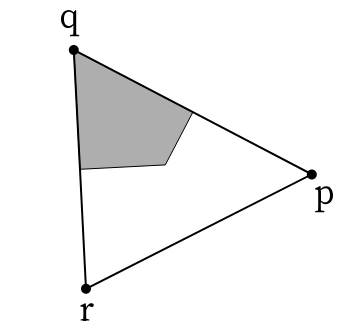
Source: [CGAL](https://doc.cgal.org/latest/Weights/group__PkgWeightsRefVoronoiRegionWeights.html)

To compute the total area, we can sum over all half-edges $(r,p)$ opposite to a vertex $q$.

This approach can also compute cell perimeter, ...

In [57]:
#| export

def get_cell_areas_traversal(geommesh: msh.GeomMesh, hemesh: msh.HeMesh) -> Float[jax.Array, " n_vertices"]:
    """
    Compute areas of cells by mesh traversal (don't use for simulation, inefficient).

    Boundary vertices get area 0.
    """
    areas = np.zeros(hemesh.n_vertices)
    bdry = hemesh.is_bdry
    for v in range(hemesh.n_vertices):
        if bdry[v]:
            areas[v] = 0
        else:
            adjacent_faces = hemesh.heface[hemesh.iterate_around_vertex(v)]
            polygon = geommesh.face_positions[adjacent_faces]
            areas[v] = trig.get_polygon_area(polygon)
    return -jnp.array(areas)

def get_voronoi_areas(vertices: Float[jax.Array, "n_vertices dim"], hemesh: msh.HeMesh) ->Float[jax.Array, " n_vertices"]:
    """Compute Voronoi area for each vertex."""
    a = hemesh.dest[hemesh.nxt]
    b = hemesh.dest[hemesh.prv]
    c = hemesh.dest
    corner_areas = jax.vmap(trig.get_voronoi_corner_area)(
        vertices[a], vertices[b], vertices[c])
    corner_areas = jnp.where(hemesh.is_bdry_he, 0, corner_areas)
    cell_areas = adj.sum_he_to_vertex_opposite(hemesh, corner_areas)
    return cell_areas

In [58]:
## Let's use the adjacency matrix to compute the area of all cells. First, compute all corner areas

a, b, c = (hemesh.dest[hemesh.nxt], hemesh.dest[hemesh.prv], hemesh.dest)

corner_areas = jax.vmap(trig.get_voronoi_corner_area)(geommesh.vertices[a], geommesh.vertices[b], geommesh.vertices[c])
cell_areas_corner = adj.sum_he_to_vertex_opposite(hemesh, corner_areas)
cell_areas_corner = cell_areas_corner.at[hemesh.is_bdry].set(0)

In [59]:
# for comparison, compute the areas by mesh traversal

cell_areas_iterative = get_cell_areas_traversal(geommesh, hemesh)
np.abs(cell_areas_iterative-cell_areas_corner).max() # works!

np.float64(5.551115123125783e-17)